In [1]:
from sklearn import datasets
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
import pandas as pd
import warnings
import numpy as np
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("Replaced.csv", encoding='ISO-8859-1')

In [3]:
df.didPurchase = (df.didPurchase)*1
df.doRecommend = (df.doRecommend)*1

df['doRecommend'] = df['doRecommend'].fillna(1)
df['didPurchase'] = df['didPurchase'].fillna(1)

## Voting Classifier Ensemble

In [4]:
X=df[['didPurchase','rating']]
y=df['doRecommend']

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
clf4 = KNeighborsClassifier(n_neighbors=10)
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3),('knn',clf4)], voting='hard')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

In [5]:
eclf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=1, solver='lbfgs',
                                                 tol=0.0001, verbose=0,
                                                 warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                

In [6]:
eclf.score( X_test, y_test)

0.9479836627388386

Voting classifier gives an accuracy of 95%

In [7]:
for clf, label in zip([clf1, clf2, clf3,clf4, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'KNN','Ensemble']):
    scores = cross_val_score(clf, X, y, cv=20, scoring='accuracy')
    print("Accuracy: %0.3f (+/- %0.3f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.944 (+/- 0.035) [Logistic Regression]
Accuracy: 0.954 (+/- 0.029) [Random Forest]
Accuracy: 0.948 (+/- 0.036) [naive Bayes]
Accuracy: 0.947 (+/- 0.037) [KNN]
Accuracy: 0.946 (+/- 0.037) [Ensemble]


***
# Staked Ensemble

In [8]:
training, valid, ytraining, yvalid = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [9]:
clf2.fit(training,ytraining)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [10]:
clf4.fit(training,ytraining)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [11]:
preds1=clf2.predict(valid)
preds2=clf4.predict(valid)

In [12]:
test_preds1=clf2.predict(X_test)
test_preds2=clf4.predict(X_test)

In [13]:
stacked_predictions=np.column_stack((preds1,preds2))
stacked_test_predictions=np.column_stack((test_preds1,test_preds2))

In [14]:
meta_model=LinearRegression()
meta_model.fit(stacked_predictions,yvalid)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [15]:
final_predictions=meta_model.predict(stacked_test_predictions)


In [16]:
count=[];
y_list=y_test.tolist()
for i in range(len(y_list)):
    if (y_list[i]==np.round(final_predictions[i])):
        count.append("Correct")
    else:
        count.append("Incorrect")

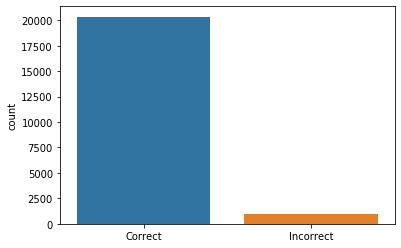

In [17]:
import seaborn as sns
sns.countplot(x=count)

In [18]:
accuracy_score(y_test,np.round(final_predictions))

0.9552603164170697